# Internal Tide and BALanced Turbulence, overview

Does Eulerian incoherence varies with `h_itide`?

To do:

- move wavemaker back south, reintroduce drifters, vary amplitudes?
- do we expect apparent incoherence with barotropic forcing?
- start setting up spectral diagnostics? what output files did Zoé used?
- will eventually need to run at 2km resolution

Knobs that will be used: `h_itide`, v-mode (?), turbulence amplitude

small h_itide: wave more likely to be transported around

v-mode = 0: more likely to be transported around, unless the wave has a larger wavelength

small turbulence amplitude: small interaction (weak eulerian incoherence), small advection (weak apparent incoherence)

Forcing width for small `h_itide`?
Theoretical tool to predict tide response?

see link to [forcing description](https://nbviewer.org/github/slgentil/croco/blob/master/configs/itbalt/readme.ipynb)

In [1]:
from glob import glob

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import xrft

import crocosi.postp as pp
import crocosi.gridop as op
import crocosi.plot as cplt

In [2]:
from dask.distributed import Client, LocalCluster

if True:
    cluster = LocalCluster()
else:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=3)
#
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:35775,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:34744,Total threads: 7
Dashboard: http://127.0.0.1:37149/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:54564,


## Load data

In [67]:
#root_path = "/home/datawork-lops-osi/equinox/itbalt/"
#root_path = "/home1/scratch/aponte/"
root_path = "/home1/scratch/slgentil/" 

#run = "fsturb_h500_a1_m0_4km_0a1000j"
run = "fsturb_h500_a1_m1_4km_0a1000j"
#run = "fsturb_h10000_a1_m0_4km_0a1000j"
#run = "fsturb_h10000_a1_m1_4km_0a1000j"

r = pp.Run(root_path+run, outputs=["surf", "his", "sec"], 
           #tdir_max=1,
           chunks=dict(sec=dict(time=2400, s_rho=1)),
           grid_periodicity=True, verbose=1)
for o in ["surf", "his", "sec"]:
    r[o] = r[o].assign_coords(time=r[o].time_counter)

pout = r.params_output

Analysing directory /home1/scratch/slgentil/fsturb_h500_a1_m1_4km_0a1000j
Found 10 segments
Search for parameters in croco.in :
Parameters detected in output.mpi :
Opening datasets: grid / surf / his / sec
Grid size: (L ,M, N) = (258, 722, 50)


In [68]:
for k, v in pout.items():
    print("{}: {}".format(k,v))

itide_omega: 0.0001454441043
itide_nmode: 2.0
itide_forcing: 1.0
itide_h: 500.0
itide_Az: 0.01
itide_y: 1500000.0
itide_dely: 10000.0
itide_start_time: 0.0
tdiag_omega: 0.0001454441043
relax_dist_south: 1000000.0
relax_L_south: 350000.0
relax_tau_in_south: 1000.0
relax_tau_out_south: 1.0
relax_dist_north: 1000000.0
relax_L_north: 350000.0
relax_tau_in_north: 1000.0
relax_tau_out_north: 1.0
depth: 4000.0
f0: 0.00010313
beta: 0.0
g: 9.81
yrbeta: 1440000.0
ini_flag: 1.0
ini_delta_rho: 0.002
ini_H_tcline: 0.15
ini_H_mld: 0.025
ini_H: 4000.0
flag_sponges: 1.0
fst_dt: 864000.0
fst_tdecay: 43200000.0
fst_Nmode: 5.0
fst_a: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
fst_xmid: 0.0
fst_xwid: 0.0
fst_delx: 100000.0
fst_ymid: 1440000.0
fst_ywid: 500000.0
fst_dely: 100000.0
fst_F: 0.0005
fst_k: 1.5e-05
fst_dk: 5e-06
fst_Lmin: 50000.0
fst_Lmax: 100000.0


---

## utils

In [46]:
def plot_Fy(p, ax=None, scale=1, ls="--", color="k", **kwargs):
    #p = r.params_output
    ymid = p["fst_ymid"]*scale
    ywid = p["fst_ywid"]*scale
    if ax is not None:
        ax.axhline(ymid-ywid, ls=ls, color=color)
        ax.axhline(ymid+ywid, ls=ls, color=color)
    else:
        plt.axhline(ymid+ywid, ls=ls, color=color)
        plt.axhline(ymid-ywid, ls=ls, color=color)

---

## bulk statistics

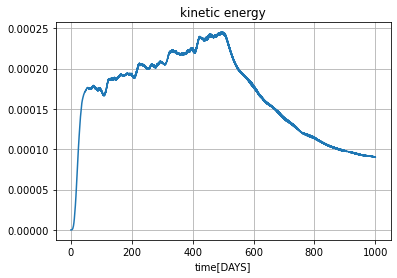

In [47]:
ax = r.stats["KINETIC_ENRG"].plot(title="kinetic energy")
#r.stats["KINETIC_ENRG"].plot(ax=ax, color="orange")
#r.stats["BTKIN_ENRG"].plot(ax=ax, lw=3., color=ax.get_lines()[-1].get_color(), 
#                           ls="--", label="barotropic")
ax.grid()

--- 

## pictures

### sea level

In [48]:
time_slice = np.arange(300,600,100)

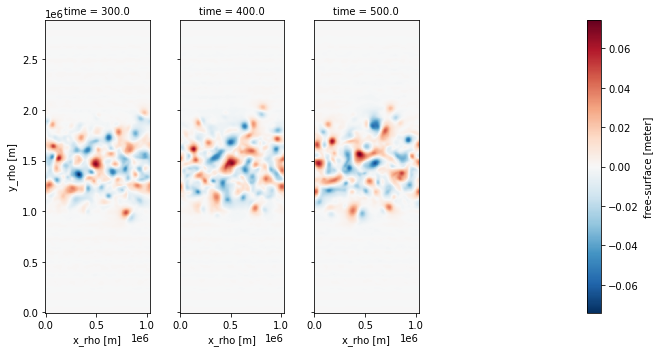

In [49]:
hdl = (r["surf"]["ssh"].sel(time=time_slice)
         .plot(x="x_rho", y="y_rho", col="time", col_wrap=4, 
               subplot_kws={"aspect":"equal"},
               aspect=.5, figsize=(10,5))
       )
plot_Fy(pout, ax=hdl.axes[0,-1])

### surface zonal velocity

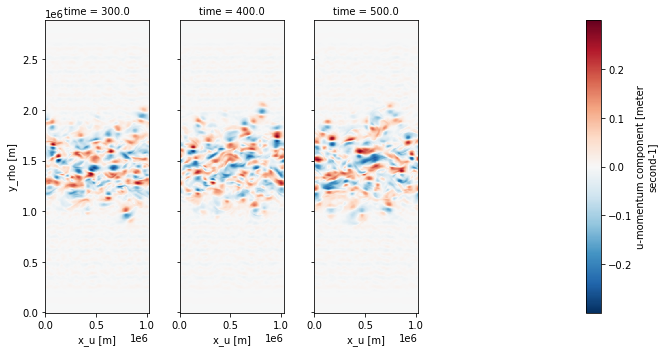

In [50]:
hdl = (r["surf"]["u"].sel(time=time_slice)
         .plot(x="x_u", y="y_rho", col="time", col_wrap=4, 
               subplot_kws={"aspect":"equal"},
               aspect=.5, figsize=(10,5))
)
plot_Fy(pout, ax=hdl.axes[0,-1])

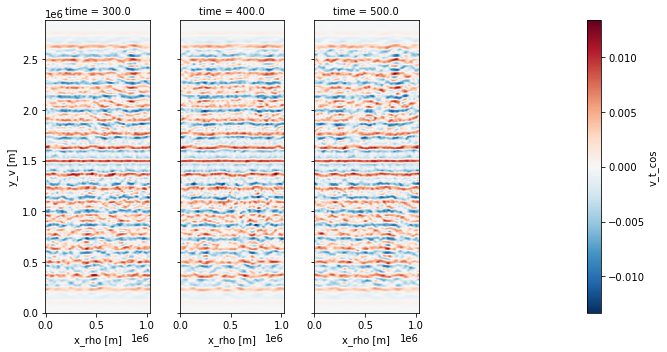

In [51]:
hdl = (r["his"]["v_t_cos"].sel(time=time_slice).sel(s_rho=0., method="nearest")
         .plot(x="x_rho", y="y_v", col="time", col_wrap=4, 
               subplot_kws={"aspect":"equal"},
               aspect=.5, figsize=(10,5))
       )
plot_Fy(pout, ax=hdl.axes[0,-1])

---

## vertical slices

In [52]:
z_u = r.get_z(zeta=r["his"].ssh_t_dirac, hgrid="u")
ds = r["his"].assign_coords(z_u = z_u)

In [53]:
time_slice = [320, 420, 520]

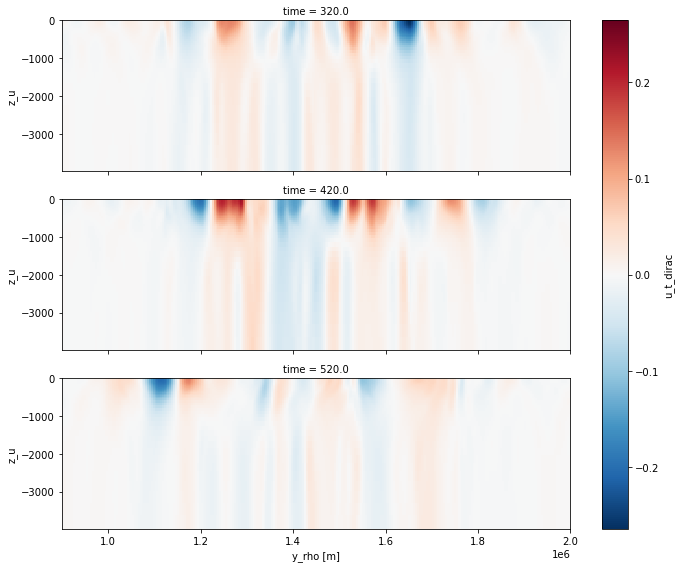

In [54]:
(ds.u_t_dirac
 .isel(x_u=0).sel(time=time_slice)
 .plot(x="y_rho", y="z_u", 
       xlim=(900*1e3,2000*1e3),
       figsize=(10,8),
       col="time", col_wrap=1)
)

---

## make movies

In [56]:
def atom(ax, da, ax_kwargs, test=None, **plt_kwargs):
    #
    xc = next((x for x in da.dims if x[0]=="x"), False)
    yc = next((x for x in da.dims if x[0]=="y"), False)
    da = da.assign_coords(x=da[xc]/1e3, y=da[yc]/1e3)
    #
    d = int(da.time)
    title = da.name+" day = %d"%(d)
    #h = (_da.time-d)*24
    #title = da.name+" day = %d / h = %.2f hour "%(d, h)
    #
    da.plot(x="x",y="y", ax=ax, **plt_kwargs)
    plot_Fy(pout, ax=ax, scale=1e-3)
    ax.set_aspect("equal", "box")
    ax.set(**ax_kwargs)
    ax.set_title(title)

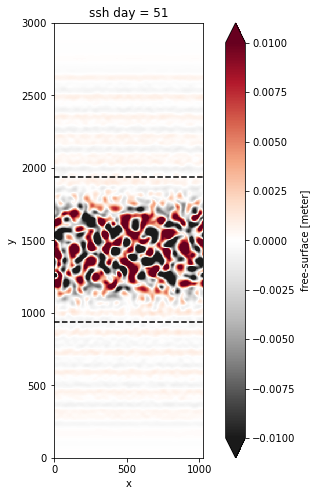

In [57]:
ssh = r["surf"]["ssh"]

da = ssh
plt_kw = {"vmin": -.01, "vmax": .01, "cmap": "RdGy_r", 
          "extend":"both"}
ax_kw = {"ylim": (0, 3000)}
cplt.movie_figure(atom, da, i=50, test=True, figsize=(8,8), 
                  ax_kwargs=ax_kw, **plt_kw)

In [ ]:
cplt.movie_wrapper(atom, client, da,
                   figsize=(8,8),
                   ax_kwargs=ax_kw, 
                   **plt_kw)
# for some reason, breaks if on a local (1 node) cluster
# with typical matplotlib thread issue:
# https://github.com/pydata/xarray/issues/1889

---

In [69]:
cluster.close()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
tornado.application - ERROR - Exception in callback <function Worker.__init__.<locals>.<lambda> at 0x2aaab9716790>
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/tornado/ioloop.py", line 905, in _run
    return self.callback()
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/worker.py", line 728, in <lambda>
    lambda: self.batched_stream.send({"op": "keep-alive"}), 60000
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/batched.py", line 136, in send
    raise CommClosedError()
distributed.comm.